# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [3]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [3]:
class Config():
    training_dir = "./siamese_images/train/"
    testing_dir = "./siamese_images/val/"
    train_batch_size = 4
    train_number_epochs = 250

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        #img0 = img0.convert("L")
        #img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [7]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [8]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((224,224)),
                                                                      transforms.RandomHorizontalFlip(),
                                                                      transforms.RandomResizedCrop(224,scale=(0.8, 1.0)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

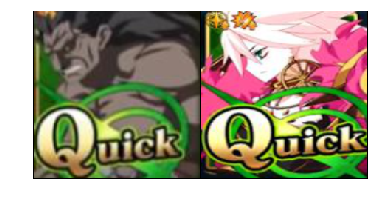

[[1.]]


In [9]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=1)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [6]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16), )
        
        self.conv2 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32), )
        
        self.conv3 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),)
        
        self.conv4 = nn.Sequential(

            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),)
        

        #[32 x 6422528], m2: [1280000 x 500]
        

        self.fc1 = nn.Sequential(
            nn.Linear(25088, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = F.max_pool2d(self.conv1(x), 2)
        output = F.max_pool2d(self.conv2(output), 2)
        output = F.max_pool2d(self.conv3(output), 2)
        output = F.max_pool2d(self.conv4(output), 2)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [11]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [10]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=Config.train_batch_size)

In [11]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [12]:
counter = []
loss_history = [] 
iteration_number= 0

In [13]:
train_dataloader

Epoch number 0
 Current loss 0.8888781070709229

Epoch number 1
 Current loss 1.000038743019104

Epoch number 2
 Current loss 1.1989901065826416

Epoch number 3
 Current loss 1.0331227779388428

Epoch number 4
 Current loss 1.962039828300476

Epoch number 5
 Current loss 0.003938440233469009

Epoch number 6
 Current loss 1.8163321018218994

Epoch number 7
 Current loss 1.7871930599212646

Epoch number 8
 Current loss 0.11373285949230194

Epoch number 9
 Current loss 1.3576936721801758

Epoch number 10
 Current loss 0.7573901414871216

Epoch number 11
 Current loss 0.9120837450027466

Epoch number 12
 Current loss 1.24178946018219

Epoch number 13
 Current loss 0.5555763244628906

Epoch number 14
 Current loss 1.302471399307251

Epoch number 15
 Current loss 0.8955012559890747

Epoch number 16
 Current loss 0.2806227207183838

Epoch number 17
 Current loss 1.263291358947754

Epoch number 18
 Current loss 1.0146230459213257

Epoch number 19
 Current loss 1.8982572555541992

Epoch number 


Epoch number 163
 Current loss 1.0144243240356445

Epoch number 164
 Current loss 1.0773297548294067

Epoch number 165
 Current loss 0.23716244101524353

Epoch number 166
 Current loss 1.176903486251831

Epoch number 167
 Current loss 0.2564845681190491

Epoch number 168
 Current loss 0.7958211898803711

Epoch number 169
 Current loss 0.2735223174095154

Epoch number 170
 Current loss 1.0385993719100952

Epoch number 171
 Current loss 0.3714129328727722

Epoch number 172
 Current loss 0.17969806492328644

Epoch number 173
 Current loss 1.0478472709655762

Epoch number 174
 Current loss 1.0648258924484253

Epoch number 175
 Current loss 1.0360708236694336

Epoch number 176
 Current loss 1.4888439178466797

Epoch number 177
 Current loss 0.8796796798706055

Epoch number 178
 Current loss 1.2147877216339111

Epoch number 179
 Current loss 0.5238317251205444

Epoch number 180
 Current loss 1.1015863418579102

Epoch number 181
 Current loss 1.0618653297424316

Epoch number 182
 Current los

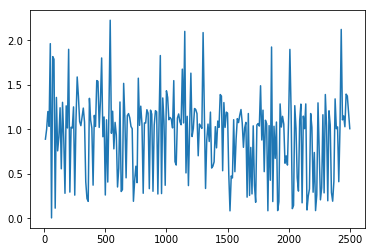

In [14]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        
    print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
    iteration_number +=10
    counter.append(iteration_number)
    loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [12]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((224,224)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
print('loading dataset')
test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

print('starting')
for i in range(3):
    _,x1,label2 = next(dataiter)
    print(x1.shape)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))



loading dataset
starting
torch.Size([1, 3, 224, 224])


NameError: name 'net' is not defined

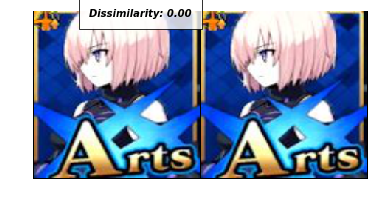

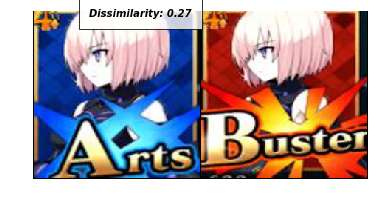

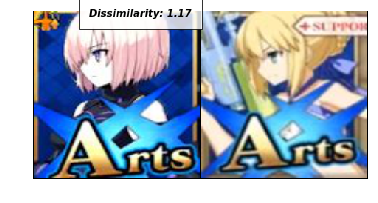

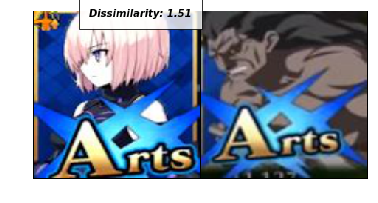

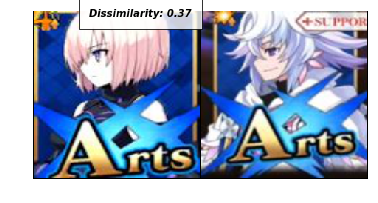

[0, 1, 4]
['arts', 'buster', 'quick', 'buster', 'buster']
['arts', 'buster', 'not_brave', 'not_brave', 'buster']
['arts', 'buster', 'buster']


In [4]:
from siamese_net_model import SiameseNetwork

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

siamese_model = SiameseNetwork()
siamese_model.load_state_dict(torch.load('models/siamese_network_cards.pth'))
siamese_model = siamese_model.to(device)
siamese_model.eval
scale=transforms.Compose([transforms.Resize((224,224)),
                             transforms.ToTensor()
                              ])


img0 = Image.open('siamese_images/train/mash/a34.JPG')
img1 = Image.open('siamese_images/train/mash/b24.JPG')
img2 = Image.open('siamese_images/train/squirtle/s1.JPG')
img3 = Image.open('siamese_images/train/hercules/h1.JPG')
img4 = Image.open('siamese_images/train/merlin/a16.JPG')

raw_card_list = [img0,img1,img2,img3,img4]
#test_dataloader = DataLoader([img0,img1,1],num_workers=0,
#                             batch_size=1,shuffle=True)
#dataiter = iter(test_dataloader)

#print(dataiter)

#x0,x1,_ = dataiter
#concatenated = torch.cat((x0,x1),-1)
#imshow(torchvision.utils.make_grid(concatenated))
def check_for_chain(card_type,card_list):
    indices = [i for i, s in enumerate(card_list) if card_type in s]
    return indices


def brave_chain_checker(base_card,raw_card_list):
    match_list = []

    for img in raw_card_list:

        img = scale(img).unsqueeze(0)

        concatenated = torch.cat((base_card,img),0)

        output1,output2 = siamese_model(base_card.cuda(),img.cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

        if euclidean_distance <.5:
            match_list.append('match')
        else:
            match_list.append('not_same')
    #print(match_list)
    return check_for_chain('match',match_list)
    
for base_card in raw_card_list:
    img_base = scale(base_card).unsqueeze(0)
    
    brave_chain_list = brave_chain_checker(img_base,raw_card_list)
    print(brave_chain_list)
    if len(brave_chain_list) >=3:
        
        break

card_list = ['arts','buster','quick','buster','buster',]
print(card_list)
for i in range(len(card_list)):
    if i not in brave_chain_list:
        card_list[i]= 'not_brave'
    else:
        continue
            
print(card_list)

test_sub_card_l = [card_list[i] for i in brave_chain_list]
print(test_sub_card_l)


In [14]:
print(brave_chain_list)
print(card_list)
test_cards = card_list

for i in range(len(test_cards)):
    
    if i in brave_chain_list:
        continue
        
    else:
        test_cards[i]= 'not_brave'
print(test_cards)

[0, 1, 2]
['arts', 'buster', 'quick', 'buster', 'buster']
['arts', 'buster', 'quick', 'not_brave', 'not_brave']


In [96]:
#torch.save(net.state_dict(), 'C:/Users/micha/Desktop/projects/fgo/models/siamese_network_cards.pth')

In [17]:
from siamese_net_model import SiameseNetwork
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

siamese_model = SiameseNetwork()
siamese_model.load_state_dict(torch.load('models/siamese_network_cards.pth'))
siamese_model = siamese_model.to(device)
siamese_model.eval()

scale=transforms.Compose([transforms.Resize((224,224)),
                            transforms.ToTensor()
                             ])
base_card = Image.open('gifs/wall.JPG')

base_card = scale(base_card).unsqueeze(0)

raw_card_list = [Image.open('gifs/s1.JPG'),
                 Image.open('gifs/s2.JPG'),
                 Image.open('siamese_images/train/chloe/c4.JPG')]
match_list = []
for img in raw_card_list:
    
        img = scale(img).unsqueeze(0)

        output1,output2 = siamese_model(base_card.cuda(),img.cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)
        print(euclidean_distance)
        if euclidean_distance <=.55:
            match_list.append('match')
        else:
            match_list.append('not_same')

print(match_list)

tensor([2.2648], device='cuda:0', grad_fn=<NormBackward1>)
tensor([2.4183], device='cuda:0', grad_fn=<NormBackward1>)
tensor([2.0401], device='cuda:0', grad_fn=<NormBackward1>)
['not_same', 'not_same', 'not_same']
